#### rasterio: 栅格数据处理

In [164]:
import numpy as np 
import rasterio as rio
from rasterio import features     ### 需要单独导入
from pprint import pprint
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio import mask
from rasterio.merge import merge


In [3]:
path_img = 'data/Section-6/s2_chenggong_20200411_6bands_20m.tif'


1. 数据读写, 数据写出以MNDWI指数值影像为例。

In [13]:
rsimg = rio.open(path_img)
pprint(rsimg.crs)
pprint(rsimg.meta)


CRS.from_epsg(32647)
{'count': 6,
 'crs': CRS.from_epsg(32647),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 1630,
 'nodata': None,
 'transform': Affine(20.0, 0.0, 874420.0,
       0.0, -20.0, 2769600.0),
 'width': 1490}


In [19]:
rsimg_arr = rsimg.read()
rsimg_arr = np.int16(rsimg_arr)    ### 一般处理数据为有符号整型

/var/folders/n0/3pzbdww50rgbs420szyd042c0000gn/T/ipykernel_79274/1917260907.py:2: RuntimeWarning: invalid value encountered in divide
  mndwi = (rsimg_arr[1]-rsimg_arr[4])/(rsimg_arr[1]+rsimg_arr[4])


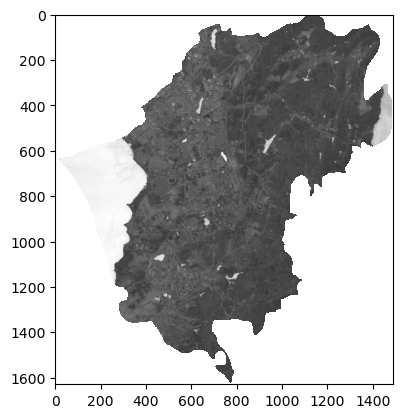

In [20]:
## 指数值计算
mndwi = (rsimg_arr[1]-rsimg_arr[4])/(rsimg_arr[1]+rsimg_arr[4])
plt.imshow(mndwi, cmap='gray')


In [22]:
## 数据写出
path_out = 'data/Section-6/s2_chenggong_20200411_mndwi.tif'
with rio.open(path_out, 'w', driver=rsimg.driver, 
                   height=rsimg.height,
                   width=rsimg.width,
                   count=1,
                   dtype=np.float32,
                   crs=rsimg.crs,
                   transform=rsimg.transform) as dst:
  dst.write(mndwi, 1)       ## the number 1 is the number of bands.


2. 矢量数据栅格化


In [44]:
path_vec = 'data/Section-6/s2_chenggong_mndwi_thre025_poly.gpkg'   ### 水体提取结果
path_rsimg = 'data/Section-6/s2_chenggong_20200411_6bands_20m.tif'    ## 呈贡区遥感影像


In [45]:
### 栅格数据与矢量数据读入
rsimg_rio = rio.open(path_rsimg)
rsimg_arr = rsimg_rio.read()
print(rsimg_arr.shape)
vec_gpd = gpd.read_file(path_vec)
print(vec_gpd.head())


(6, 1630, 1490)
   DN                                           geometry
0   1  POLYGON ((889860.000 2768500.000, 889860.000 2...
1   1  POLYGON ((889920.000 2768380.000, 889920.000 2...
2   1  POLYGON ((894840.000 2768060.000, 894840.000 2...
3   1  POLYGON ((895420.000 2767440.000, 895420.000 2...
4   1  POLYGON ((892400.000 2767340.000, 892400.000 2...


In [39]:
### 矢量数据栅格化
vec_to_raster = features.rasterize(shapes = vec_gpd.geometry,
                                out_shape = rsimg_arr[0].shape,    ## 栅格行列与所提供遥感影像一致
                                fill = 0,
                                out = None,
                                transform = rsimg_rio.transform,
                                default_value = 1,
                                dtype = None)


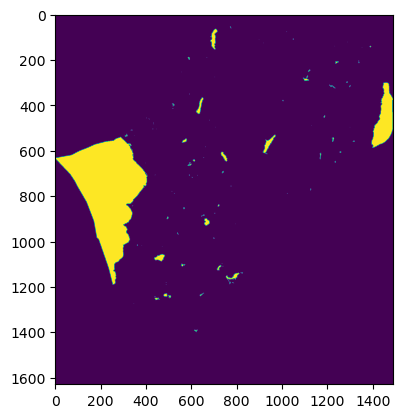

In [40]:
plt.imshow(vec_to_raster)

3. 栅格数据矢量化

In [61]:
path_raster = 'data/Section-6/s2_chenggong_mndwi_thre025.tif'
raster_rio = rio.open(path_raster)
pprint(raster_rio.meta)
raster_arr = raster_rio.read(1)
print(raster_arr.shape)


{'count': 1,
 'crs': CRS.from_epsg(32647),
 'driver': 'GTiff',
 'dtype': 'int16',
 'height': 1630,
 'nodata': None,
 'transform': Affine(20.0, 0.0, 874420.0,
       0.0, -20.0, 2769600.0),
 'width': 1490}
(1630, 1490)


In [97]:
from shapely.geometry import shape

values, geos = [], []
for geo, value in features.shapes(raster_arr, transform=raster_rio.transform):
  # if value == 1:
  values.append(value)  
  geos.append(geo)
geos = [shape(geo) for geo in geos]   ### geojason -> shapely polygon
dict = {'DN': values, 
        'geometry': geos}
region_gpd = gpd.GeoDataFrame(dict, crs="EPSG:32647")
region_gpd.head()

,DN,geometry
0,1.0,"POLYGON ((889860.000 2768500.000, 889860.000 2..."
1,1.0,"POLYGON ((889920.000 2768380.000, 889920.000 2..."
2,1.0,"POLYGON ((894840.000 2768060.000, 894840.000 2..."
3,1.0,"POLYGON ((895420.000 2767440.000, 895420.000 2..."
4,1.0,"POLYGON ((892400.000 2767340.000, 892400.000 2..."


<Axes: >

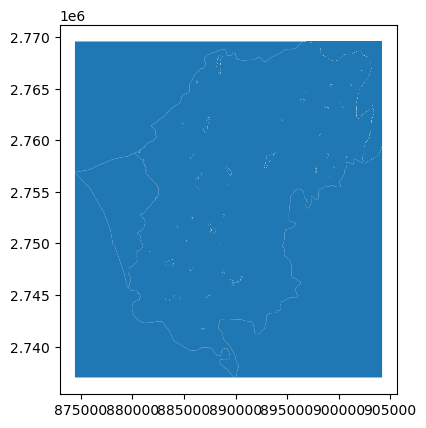

In [96]:
region_gpd.plot()


4. 矢量裁剪

In [100]:
path_rsimg = 'data/Section-6/s2_chenggong_20200411_6bands_20m.tif'    ## 呈贡区遥感影像
path_vec = 'data/Section-6/subset.gpkg'


In [159]:
rsimg_rio.dtypes


('uint16', 'uint16', 'uint16', 'uint16', 'uint16', 'uint16')

In [162]:
rsimg_rio = rio.open(path_img)
pprint(rsimg_rio.meta)
vec_gpd = gpd.read_file(path_vec)
vec_gpd = vec_gpd.to_crs(32647)
print(vec_gpd.crs)

{'count': 6,
 'crs': CRS.from_epsg(32647),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 1630,
 'nodata': None,
 'transform': Affine(20.0, 0.0, 874420.0,
       0.0, -20.0, 2769600.0),
 'width': 1490}
EPSG:32647


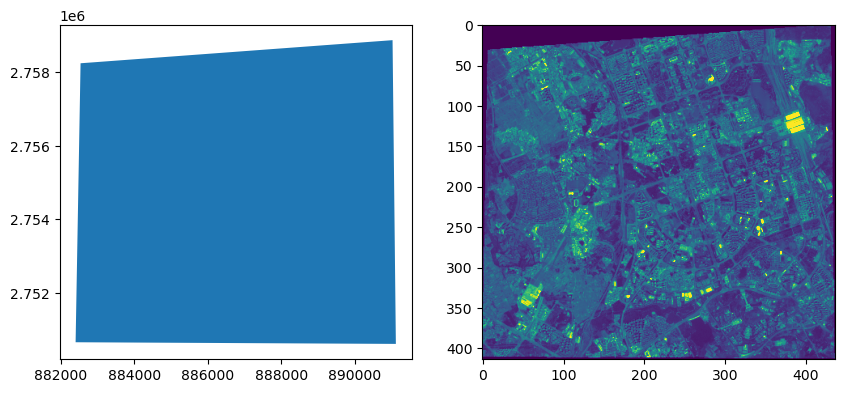

In [198]:
rsimg_sub = mask.mask(rsimg_rio, vec_gpd.geometry, crop=True, nodata=0)[0]
fig, ax = plt.subplots(1,2,figsize=(10,5))
vec_gpd.plot(ax = ax[0])
ax[1].imshow(rsimg_sub[0], vmin=0, vmax=3000)


5. 影像拼接

In [165]:
path_reg1 = 'data/Section-6/s2_chenggong_20200411_6bands_20m_subs.tif'
path_reg2 = 'data/Section-6/s2_chenggong_20200411_6bands_20m_subs2.tif'


In [166]:
rsimg_reg1_rio = rio.open(path_reg1)
rsimg_reg2_rio = rio.open(path_reg2)


In [168]:
mosaic, out_trans = merge([rsimg_reg1_rio, rsimg_reg2_rio])


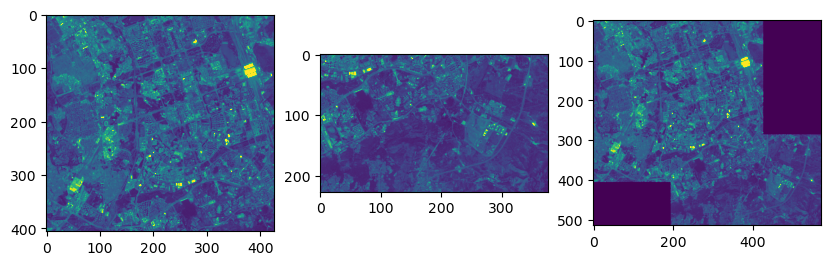

In [197]:
fig, ax= plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(rsimg_reg1_rio.read(1), vmin=0, vmax=3000)
ax[1].imshow(rsimg_reg2_rio.read(1), vmin=0, vmax=3000)
ax[2].imshow(mosaic[0], vmin=0, vmax=3000)


重投影（比较麻烦，建议采用gdal命令行工具或gdal.Warp()函数）